In [47]:
import numpy as np
import matplotlib.pyplot as plt
import cirq, scipy
import qsimcirq
import time as clock
import tqdm

In [2]:
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1.j],[1.j,0]])
Z = np.array([[1,0],[0,-1]])

XXg = np.kron(X,X)
YYg = np.kron(Y,Y)
ZZg = np.kron(Z,Z)

"""Define a custom single-qubit gate."""
class Coupling(cirq.Gate):
    def __init__(self,v,time):
        super(Coupling, self)
        self.time = time 
        self.v = v

    def _num_qubits_(self):
        return 2

    def _unitary_(self):
        return scipy.linalg.expm(-1.j*self.time*(self.v[0]*XXg +self.v[1]*YYg + self.v[2]*ZZg
            ) )

    def _circuit_diagram_info_(self, args):
        return "G(t,v)", "G(t,v)"

def do_step(circuit, qrs, coupling, t):
    N = len(qrs)

    _ = 0
    for i in range(0,N,2):
        circuit.append(Coupling(coupling[_,:],t).on(qrs[i],qrs[i+1]))
        _ +=1
        
    for i in range(1,N-1,2):
        circuit.append(Coupling(coupling[_,:],t).on(qrs[i],qrs[i+1]))
        _+=1
        
    return circuit
    


In [87]:
#Lets do an open disorder XX chain: J (XX + YY) + h_jZ_j
# Define qubits and a short circuit.
def Heisenberg_chain(N, field, coupling, dt = 1, step = 1):
    qrs = cirq.LineQubit.range(N)
    circuit =  cirq.Circuit()

    # state preparation 
    #let start for a wall for now so |111000> 
    circuit.append([cirq.X(qrs[i]) for i in range(0,N//2)])
    circuit.append([cirq.I(qrs[i]) for i in range(N//2,N)])
    
    for _ in range(step):
        # field in the z direction 
        circuit.append([cirq.rz(dt*field[i]).on(qrs[i]) for i in range(0,N)])
        # XX+YY+ZZ coupling
        circuit = do_step(circuit, qrs, coupling, dt)

    
    # print(circuit)
    return circuit

N = 16
J = 1

field = np.random.uniform(-1,1,size = N)
coupling = np.random.normal(0,0.3,size=3*(N-1))
coupling = J*np.ones_like(coupling)
coupling = coupling.reshape(-1,3)
coupling[:,-1] = 0 #ZZ term is 0 

dt = 0.1 #time step 

circuit = Heisenberg_chain(N,field, coupling, dt = dt, step = 1 )
print(circuit)


#create the observables
qrs =  cirq.LineQubit.range(N)
O = []
O_index = []
for i in range(N):
    O.append(cirq.Z(qrs[i]) )
    O_index.append([i])

for i in range(N):
    for j in range(i+1,N):
        O.append(cirq.X(qrs[i])*cirq.X(qrs[j]) )
        O_index.append([i,j])
        
O_index = np.array(O_index)
# O = [cirq.XX(qrs[0],qrs[1])]

0: ────X───Rz(-0.004π)───G(t,v)────────────
                         │
1: ────X───Rz(0.009π)────G(t,v)───G(t,v)───
                                  │
2: ────X───Rz(0.007π)────G(t,v)───G(t,v)───
                         │
3: ────X───Rz(0.012π)────G(t,v)───G(t,v)───
                                  │
4: ────X───Rz(0.028π)────G(t,v)───G(t,v)───
                         │
5: ────X───Rz(-0.027π)───G(t,v)───G(t,v)───
                                  │
6: ────X───Rz(0.032π)────G(t,v)───G(t,v)───
                         │
7: ────X───Rz(0.022π)────G(t,v)───G(t,v)───
                                  │
8: ────I───Rz(0.014π)────G(t,v)───G(t,v)───
                         │
9: ────I───Rz(-0.03π)────G(t,v)───G(t,v)───
                                  │
10: ───I───Rz(0)─────────G(t,v)───G(t,v)───
                         │
11: ───I───Rz(-0.019π)───G(t,v)───G(t,v)───
                                  │
12: ───I───Rz(-0.031π)───G(t,v)───G(t,v)───
                         │
13: ───I───Rz(-0.031π)─

/var/folders/8p/vv7_36t518g8k99lx5mkqlxc0000gn/T/ipykernel_55415/1582115649.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  O_index = np.array(O_index)


In [88]:
# Simulate the circuit with qsim and print the runtime.
options = {'t': 8,'f':3}
# options = qsimcirq.QSimOptions(use_gpu=True, gpu_mode = 0, max_fused_gate_size=4) #for gpu (we can do it on the cern cluster) 
qsim_simulator = qsimcirq.QSimSimulator(options)

results = []
for n in tqdm.tqdm(range(1,200)):
    circuit = Heisenberg_chain(N,field, coupling, dt = dt, step = n)
    qsim_results = qsim_simulator.simulate_expectation_values(circuit,observables = O)
    results.append(qsim_results)
results = np.array(results)

100%|███████████████████████████████████████████████████████████████| 199/199 [01:34<00:00,  2.11it/s]


(199, 136)
2 3
7 8


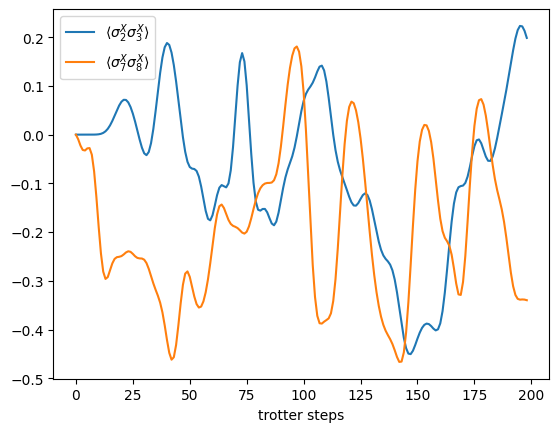

In [91]:
results = np.array(results)
print(results.shape)
for v in [45,100]:
    if len(O_index[v])==1:
        x = int(np.array(O_index[v]))
    
        l = r'$\langle \sigma^z_{} \rangle $'.format(x)
    else:
        x = int(np.array(O_index[v][0]))
        y = int(np.array(O_index[v][1]))
        print(x,y)
        l = r'$\langle \sigma^X_{{{}}} \sigma^X_{{{}}} \rangle$'.format(x,y)
    plt.plot(results[:,v],label=l)
plt.xlabel('trotter steps')
plt.legend()
plt.savefig('quench.png')